# MSDS 7331 Mini - Project 1  

## SVM and Logistic Modeling

Professor: Dr. Jake Drew  
Team: Steven Hayden, Josephine MacDaniel, Korey MacVittie, Afreen Siddiqui, Eduardo Cantu

## Models

In [20]:
#load Libraries
import pandas as pd
import numpy as np
import seaborn as seaborn
import matplotlib.pyplot as plt
import matplotlib as mp1
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
#Load Data
Accident_df_2016 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2016.csv',low_memory=False)
Accident_df_2015 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2015.csv',low_memory=False)
Accident_df = pd.concat([Accident_df_2015,Accident_df_2016])

### Data Cleaning

In [22]:
# Displays the record count of non-null Values per attribute and their data type. 
Accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66978 entries, 0 to 34438
Data columns (total 71 columns):
Unnamed: 0                                                     66978 non-null int64
state_number                                                   66978 non-null int64
state_name                                                     66978 non-null object
consecutive_number                                             66978 non-null int64
number_of_vehicle_forms_submitted_all                          66978 non-null int64
number_of_motor_vehicles_in_transport_mvit                     66978 non-null int64
number_of_parked_working_vehicles                              66978 non-null int64
number_of_forms_submitted_for_persons_not_in_motor_vehicles    66978 non-null int64
number_of_persons_not_in_motor_vehicles_in_transport_mvit      66978 non-null int64
number_of_persons_in_motor_vehicles_in_transport_mvit          66978 non-null int64
number_of_forms_submitted_for_persons_in_motor_veh

In [23]:

#check for duplicate records. It displays the maximum count of a duplicated record. 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()


2

In [24]:
#Drop duplicate records and keeps the most recent record. We assume the most resent is the most accurate 
Accident_df = Accident_df.drop_duplicates(['consecutive_number'],keep = 'last')

#check for duplicate records. It displays the maximum count of a duplicated record. 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()

1

There are many accidents with missing data regarding the crash time and the arrival time of responders. This information is need for the dependent variable and in turn is crucial for our analysis. That is why it was decided to drop these records with missing data instead of filling the gaps with the mean.  The amount records dropped is about a third of the original data set. 

In [25]:
#Remove any recoreds without  time informaiton for arival and crash time
count_no_rec= Accident_df[(Accident_df['hour_of_crash']>24) | (Accident_df['hour_of_arrival_at_scene']>24)]
Accident_df = Accident_df[(Accident_df['hour_of_crash']<=24) & (Accident_df['hour_of_arrival_at_scene']<=24)]
print(count_no_rec.consecutive_number.count(), 'records were removed due to missing time data.') 


19149 records were removed due to missing time data.


In [26]:
# Add a new Feature. This is the ratio between the number of fatalities and the people involved in the accident.
Accident_df['Fatalities_ratio'] = Accident_df.number_of_fatalities/(Accident_df.number_of_persons_not_in_motor_vehicles_in_transport_mvit + Accident_df.number_of_persons_in_motor_vehicles_in_transport_mvit)

#Converts hour and min to datetime type
#crash
Accident_df.hour_of_crash = pd.to_timedelta(Accident_df.hour_of_crash,unit ='h')
Accident_df.minute_of_crash= pd.to_timedelta(Accident_df.minute_of_crash,unit ='m')
#arrival
Accident_df.hour_of_arrival_at_scene = pd.to_timedelta(Accident_df.hour_of_arrival_at_scene,unit ='h')
Accident_df.minute_of_arrival_at_scene = pd.to_timedelta(Accident_df.minute_of_arrival_at_scene,unit ='m')

#concatenates Hour and Minutes together 
Accident_df['Crash_Time'] = Accident_df['hour_of_crash'] + Accident_df['minute_of_crash'] 
Accident_df['Arrival_Time'] = Accident_df['hour_of_arrival_at_scene'] + Accident_df['minute_of_arrival_at_scene']
#creates a response_time variable from the two fields above and converts to min
Accident_df['Response_Time'] = Accident_df['Arrival_Time'] - Accident_df['Crash_Time']
total_response_time_in_min = pd.DatetimeIndex(Accident_df['Response_Time'])
Accident_df['Response_Time']= total_response_time_in_min.hour * 60 + total_response_time_in_min.minute


#gut check of calculation 
Accident_df[['hour_of_crash','minute_of_crash','Crash_Time','hour_of_arrival_at_scene','minute_of_arrival_at_scene','Arrival_Time','Response_Time']].head()

,hour_of_crash,minute_of_crash,Crash_Time,hour_of_arrival_at_scene,minute_of_arrival_at_scene,Arrival_Time,Response_Time
196,20:00:00,00:47:00,20:47:00,21:00:00,00:01:00,21:01:00,14
240,19:00:00,00:10:00,19:10:00,19:00:00,00:24:00,19:24:00,14
274,14:00:00,00:18:00,14:18:00,14:00:00,00:25:00,14:25:00,7
312,23:00:00,00:23:00,23:23:00,23:00:00,00:29:00,23:29:00,6
959,16:00:00,00:01:00,16:01:00,16:00:00,00:12:00,16:12:00,11


The National Fire Protection Association's (NFPA) has established standard for response time and procedures for Emergency Medical Service (EMS) to adhere to. 

From EMSword.com "The NFPA 1710 standard is based upon a combination of accepted practices and more than 30 years of study, research, testing and validation. Members of the 1710 committee that developed the standard include representatives from various fire agencies and the International Association of City/County Managers (ICMA)."

The NFPA 1710 standard allows for a one-minute call evaluation and preparation, four minutes for the arrival of a unit with first responder. For a situation that requires an advanced life support equipment like an ambulance, their standard is 8 minutes after the call preparation.  

We chose to use their standards as threshold to determine if the paramedics got to the scene of the accident in time. This would be a binary response 0, for not arriving within 9 minutes of the accident and 1 for being within the 9 minutes. 
Source: https://www.emsworld.com/article/10324786/ems-response-time-standards



In [27]:
#creates the binary variable 'within 9 minutes NFPA standard'
Accident_df['within 9 minutes NFPA standard'] = np.where(Accident_df['Response_Time']<=9,1,0)
#Accident_df[['Response_Time','within 9 minutes NFPA standard']].head(10) # Verify the binary variable

Since the logistic regresion will predict if the paramedic got on time to the scene of the accident we would select the attributes that we think affect this variable.

First we would check what columns are available.

In [28]:
#Displays all the available attributes on the dataset
Accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16230 entries, 196 to 34438
Data columns (total 76 columns):
Unnamed: 0                                                     16230 non-null int64
state_number                                                   16230 non-null int64
state_name                                                     16230 non-null object
consecutive_number                                             16230 non-null int64
number_of_vehicle_forms_submitted_all                          16230 non-null int64
number_of_motor_vehicles_in_transport_mvit                     16230 non-null int64
number_of_parked_working_vehicles                              16230 non-null int64
number_of_forms_submitted_for_persons_not_in_motor_vehicles    16230 non-null int64
number_of_persons_not_in_motor_vehicles_in_transport_mvit      16230 non-null int64
number_of_persons_in_motor_vehicles_in_transport_mvit          16230 non-null int64
number_of_forms_submitted_for_persons_in_motor_v

From all the attributes in the dataset we would only select a subset to predict the if the paramedics will arrive on time or not.  
* **state_name:** This attribute can give us an indication if there are states that would have a better response time in an accident than others.
* **route_signing_name:** This can give us an insigth on the type of roads where the paramedics find more challenging to get.  
* **light_condition_name:** We want to underdstand how much the lightning coditions affect the ability of the paramedics to get on time to the scene of the accident.  
* **atmospheric_conditions_name:** Adding this attribute, we want to see how the weather conditions affect the reaction time of the paramedics.  
* **within 9 minutes NFPA standard:**  This is our response variable, where 1 means that the paramedics get on time to the scene of the accident. As mentioned before, this threshold is set by the NFPA and is 9 minutes. This field will be 0 if the paramedics take more than 9 minutes to get the the accident.

In [29]:
#Make a copy of the original Data
Accident_forLr=Accident_df.copy()

# 1. Remove attributes that just arent useful for us
for col in ['Unnamed: 0',
             'state_number',
             'consecutive_number',
             'county',
             'city',
             'day_of_crash',
             'month_of_crash',
             'year_of_crash',
             'day_of_week',
             'hour_of_crash',
             'minute_of_crash',
             'national_highway_system',
             'land_use',
             'land_use_name',
             'functional_system',
             'functional_system_name',
             'ownership',
             'ownership_name',
             'route_signing',
             'trafficway_identifier',
             'trafficway_identifier_2',
             'latitude',
             'longitude',
             'special_jurisdiction',
             'special_jurisdiction_name',
             'first_harmful_event',
             'first_harmful_event_name',
             'manner_of_collision',
             'manner_of_collision_name',
             'relation_to_junction_within_interchange_area',
             'relation_to_junction_specific_location',
             'relation_to_junction_specific_location_name',
             'type_of_intersection',
             'work_zone',
             'relation_to_trafficway',
             'relation_to_trafficway_name',
             'light_condition',
             'atmospheric_conditions_1',
             'atmospheric_conditions_1_name',
             'atmospheric_conditions_2',
             'atmospheric_conditions_2_name',
             'atmospheric_conditions',
             'school_bus_related',
             'rail_grade_crossing_identifier',
             'hour_of_notification',
             'minute_of_notification',
             'hour_of_arrival_at_scene',
             'minute_of_arrival_at_scene',
             'hour_of_ems_arrival_at_hospital',
             'minute_of_ems_arrival_at_hospital',
             'related_factors_crash_level_1',
             'related_factors_crash_level_1_name',
             'related_factors_crash_level_2',
             'related_factors_crash_level_2_name',
             'related_factors_crash_level_3',
             'related_factors_crash_level_3_name',
             'milepoint',
             'number_of_parked_working_vehicles',
             'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
             'number_of_persons_not_in_motor_vehicles_in_transport_mvit',
             'number_of_persons_in_motor_vehicles_in_transport_mvit',
             'number_of_forms_submitted_for_persons_in_motor_vehicles',
             'timestamp_of_crash',
             'number_of_fatalities',
             'number_of_drunk_drivers',
             'Fatalities_ratio',
             'number_of_vehicle_forms_submitted_all',
             'Crash_Time',
             'Arrival_Time',
             'Response_Time',
             'number_of_motor_vehicles_in_transport_mvit']:
                    if col in Accident_forLr:
                        del Accident_forLr[col]
# List the columns left in the df
list(Accident_forLr)

#Accident_forLr.head(20)

['state_name',
 'route_signing_name',
 'light_condition_name',
 'atmospheric_conditions_name',
 'within 9 minutes NFPA standard']

Any observation value on the selected attributes that is reported as *Unknown, Other, or Not Reported* would be removed from the dataset. This values do not bring any value when it comes to predict the response time of the paramedics.

In [30]:
# Check for columns that might not be needed
print("Unique values for 'route_signing_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'atmospheric_conditions_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'light_condition_name':" , Accident_forLr.light_condition_name.unique())


Unique values for 'route_signing_name': ['Rain' 'Snow' 'Clear' 'Cloudy' 'Unknown' 'Sleet, Hail' 'Blowing Snow'
 'Not Reported' 'Fog, Smog, Smoke' 'Severe Crosswinds'
 'Freezing Rain or Drizzle' 'Blowing Sand, Soil, Dirt' 'Other'] 

Unique values for 'atmospheric_conditions_name': ['Rain' 'Snow' 'Clear' 'Cloudy' 'Unknown' 'Sleet, Hail' 'Blowing Snow'
 'Not Reported' 'Fog, Smog, Smoke' 'Severe Crosswinds'
 'Freezing Rain or Drizzle' 'Blowing Sand, Soil, Dirt' 'Other'] 

Unique values for 'light_condition_name': ['Dark – Not Lighted' 'Daylight' 'Dark – Lighted' 'Dusk' 'Dawn'
 'Dark – Unknown Lighting' 'Not Reported' 'Unknown' 'Other']


In [31]:
# Removes observations with an unknown informaiton in the route, atmospheric conditions and state name
Accident_forLr= Accident_forLr[(Accident_forLr['route_signing_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['route_signing_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Not Reported')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Not Reported')]
Accident_forLr.count()

state_name                        14706
route_signing_name                14706
light_condition_name              14706
atmospheric_conditions_name       14706
within 9 minutes NFPA standard    14706
dtype: int64

Review that the observations have been removed from the dataset. The undesired obsrvations are removed.

In [32]:
print("Unique values for 'route_signing_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'atmospheric_conditions_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'light_condition_name':" , Accident_forLr.light_condition_name.unique())

Unique values for 'route_signing_name': ['Rain' 'Snow' 'Clear' 'Cloudy' 'Sleet, Hail' 'Blowing Snow'
 'Fog, Smog, Smoke' 'Severe Crosswinds' 'Freezing Rain or Drizzle'
 'Blowing Sand, Soil, Dirt'] 

Unique values for 'atmospheric_conditions_name': ['Rain' 'Snow' 'Clear' 'Cloudy' 'Sleet, Hail' 'Blowing Snow'
 'Fog, Smog, Smoke' 'Severe Crosswinds' 'Freezing Rain or Drizzle'
 'Blowing Sand, Soil, Dirt'] 

Unique values for 'light_condition_name': ['Dark – Not Lighted' 'Daylight' 'Dark – Lighted' 'Dusk' 'Dawn'
 'Dark – Unknown Lighting']


In [33]:
# Rearrange colums
Accident_forLr=Accident_forLr[['within 9 minutes NFPA standard','state_name','route_signing_name','atmospheric_conditions_name','light_condition_name']]
#list(Accident_forLr)  # Check for the correct column sequence

The section below will perform the one-hot encoding of the variables on the dataset. This is to prepare the data in such a way that can be use for our logistic regresion.

In [34]:
# perform one-hot encoding of the categorical data "state_name"
tmp_state_df = pd.get_dummies(Accident_forLr.state_name,prefix='state')
#tmp_state_df.head(20)

# perform one-hot encoding of the categorical data "route_signing_name"
tmp_route_df = pd.get_dummies(Accident_forLr.route_signing_name,prefix='route')
#tmp_route_df.head(20)

# perform one-hot encoding of the categorical data "atmospheric_conditions_name"
tmp_atmos_df = pd.get_dummies(Accident_forLr.atmospheric_conditions_name,prefix='atmos')
#tmp_atmos_df.head(20)

# perform one-hot encoding of the categorical data "atmospheric_conditions_name"
tmp_light_df = pd.get_dummies(Accident_forLr.light_condition_name, prefix='light')
#tmp_atmos_df.head(20)

Accident_forLr = pd.concat((Accident_forLr,tmp_state_df,tmp_route_df,tmp_atmos_df,tmp_light_df), axis=1) # add back into the dataframe
list(Accident_forLr)
#delete the categorical variable columns
del Accident_forLr['state_name']
del Accident_forLr['route_signing_name']
del Accident_forLr['atmospheric_conditions_name']
del Accident_forLr['light_condition_name']

#list(Accident_forLr) # Check for the last colums

In [ ]:
#Accident_forLr.count() # Count Records and show columns

### Logistic Regression Model

### Data Split and Cross Validation Setup
In this logistic regresion we would be splitting our dataset into a Training and Test set. The split is going to be 80 % for training and the other 20 % for testing. The ratio used is accepted split in the research community, and we did not see any reason to deviate from this ratio. A Cross Validation of ten fold would be performed to validate the model. 

In [35]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'within 9 minutes NFPA standard' in Accident_forLr:
    y = Accident_forLr['within 9 minutes NFPA standard'].values # get the labels we want
    del Accident_forLr['within 9 minutes NFPA standard'] # get rid of the class label
    X = Accident_forLr.values # use everything else to predict!
    
        ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
        #    have converted them into simple matrices to use with scikit learn

# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10  #number of Cross Validation folds
num_instances = len(y)

# Cross Validation Object
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(X) # This prints all the dependant variables
print(cv_object) # This print the Data split object

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


In [36]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
OnTime_lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
acc_List = []
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    OnTime_lr_clf.fit(X_train,y_train)  # train object
    y_hat = OnTime_lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    acc_List.append(acc)
    iter_num+=1

    
# The Code above randomly creates a new training and testing set
# so there will multiple accuracy measurements
# We have taken the of all these measurements below

print('\n','\n','\n','\n',"==========================") 
print("average accuracy",np.mean(acc_List))



====Iteration 0  ====
accuracy 0.641400407885792
confusion matrix
 [[1266  391]
 [ 664  621]]
====Iteration 1  ====
accuracy 0.6447994561522774
confusion matrix
 [[1236  369]
 [ 676  661]]
====Iteration 2  ====
accuracy 0.6498980285520054
confusion matrix
 [[1267  358]
 [ 672  645]]
====Iteration 3  ====
accuracy 0.6271244051665533
confusion matrix
 [[1253  362]
 [ 735  592]]
====Iteration 4  ====
accuracy 0.6529571719918423
confusion matrix
 [[1276  406]
 [ 615  645]]
====Iteration 5  ====
accuracy 0.6549966009517335
confusion matrix
 [[1334  357]
 [ 658  593]]
====Iteration 6  ====
accuracy 0.6553365057783821
confusion matrix
 [[1277  363]
 [ 651  651]]
====Iteration 7  ====
accuracy 0.6587355540448674
confusion matrix
 [[1275  355]
 [ 649  663]]
====Iteration 8  ====
accuracy 0.659755268524813
confusion matrix
 [[1309  330]
 [ 671  632]]
====Iteration 9  ====
accuracy 0.6410605030591434
confusion matrix
 [[1260  406]
 [ 650  626]]

 
 
 
average accuracy 0.6486063902107408


 The mean of the 10-fold cross validation is indicated above. 

### Support Vector Machine Model

In [49]:
# Code to run through the cross validation loop and set the training and testing variable for one single iteration 
#Code addapted from the Dataming Notbooks. Logistic Regression and SVM Notbook 4
from sklearn.preprocessing import StandardScaler
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
#scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [51]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train, y_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.6271244051665533
[[1328  287]
 [ 810  517]]


In [53]:
# Running the model with scaled data (optional team willl make a call)
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.6366417403127125
[[1238  377]
 [ 692  635]]


In [54]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(9186, 73)
(9186,)
[4712 4474]


In [57]:
#Using Linear Kernel (source: https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/)
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train) 
 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [58]:
#To make predictions, the predict method of the SVC class is used. 
y_pred = svclassifier.predict(X_test)

In [59]:
#Confusion matrix, precision, recall, and F1 measures are the most commonly used metrics for classification tasks. 
#Scikit-Learn's metrics library contains the classification_report and confusion_matrix methods, which can be readily used to find out the values for these important metrics.
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[1299  316]
 [ 783  544]]
             precision    recall  f1-score   support

          0       0.62      0.80      0.70      1615
          1       0.63      0.41      0.50      1327

avg / total       0.63      0.63      0.61      2942



[[-3.91256983e-01 -3.90994648e-01 -3.90894987e-01 -3.91203810e-01
  -3.90716770e-01  1.60798532e+00  1.60783968e+00  1.60842808e+00
   0.00000000e+00  1.60835162e+00 -3.91159717e-01  1.00000000e+00
  -3.91192207e-01  0.00000000e+00 -3.91182633e-01 -3.91330253e-01
  -3.91253298e-01 -3.91246758e-01 -3.91380868e-01 -3.91592298e-01
   1.60835252e+00 -3.90652066e-01 -3.90913389e-01 -3.91218915e-01
  -3.91217523e-01 -3.91395473e-01 -3.91004405e-01  1.60773622e+00
  -3.91499180e-01 -3.91426703e-01 -3.91296444e-01  1.60820422e+00
  -3.90405709e-01 -3.91155472e-01 -3.91187596e-01 -3.91312974e-01
  -3.90978495e-01  1.60761046e+00  1.00000000e+00 -3.91015843e-01
  -3.91218487e-01 -3.91170069e-01 -3.91186715e-01 -3.91150597e-01
  -3.91558183e-01 -3.90879339e-01 -3.91473601e-01 -3.91235307e-01
  -3.91218802e-01 -3.91331611e-01 -2.85700012e-01 -2.85900891e-01
  -2.85309270e-01  1.71363398e+00 -2.85542961e-01 -2.85655365e-01
  -2.85525483e-01  0.00000000e+00  1.58783959e-04  1.53059363e-04
   2.04460

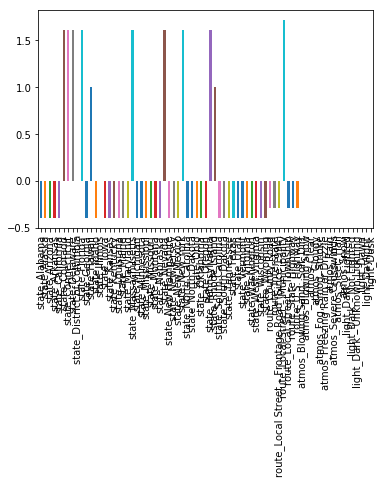

In [62]:
## using linear kernel to get the bar chart of coef
print(svclassifier.coef_)
weights = pd.Series(svclassifier.coef_[0],index=Accident_forLr.columns)
weights.plot(kind='bar')

## Model Discussion

## Logistic Regression Weight Interpretation

From the weights below, you can easily tell the direction of the relationship each dependent variable had. A negative value suggests that, if variable is true or increases, the likely hood of an on time arrival would increase as well.  We will need to scale these attributes to see the magnitude each one has on arrival time. 

In [21]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
#Generates weights from the LR model.


# iterate over the coefficients 
weights = OnTime_lr_clf.coef_.T # take transpose to make a column vector
variable_names = Accident_forLr.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    


state_Alabama has weight of -0.4899829837392541
state_Alaska has weight of -0.14337924768566845
state_Arizona has weight of 0.3232682314219525
state_Arkansas has weight of -0.45203186632788106
state_California has weight of -0.21335616389767512
state_Colorado has weight of 0.6327633153712515
state_Connecticut has weight of 0.8458498665882528
state_Delaware has weight of 0.9540642307433653
state_District of Columbia has weight of 0.5062271668474364
state_Florida has weight of 0.5612335530299186
state_Georgia has weight of 0.24518265462769034
state_Hawaii has weight of 0.4356375585345174
state_Idaho has weight of -0.11161754368952305
state_Illinois has weight of 0.38979241292011957
state_Iowa has weight of -0.12233878747115826
state_Kansas has weight of -0.6562818149204045
state_Kentucky has weight of 0.08049679931043642
state_Louisiana has weight of -0.330356054142514
state_Maine has weight of -0.013601800827420287
state_Maryland has weight of -0.004566366469773999
state_Massachusetts h

## Discuses in meeting 
Weights changed to negative 


In [22]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
OnTime_lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
OnTime_lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = OnTime_lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(OnTime_lr_clf.coef_.T,Accident_forLr.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

C:\Users\shayden\AppData\Local\Continuum\anaconda32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shayden\AppData\Local\Continuum\anaconda32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shayden\AppData\Local\Continuum\anaconda32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


accuracy: 0.6420802175390891
[[1269  433]
 [ 620  620]]
light_Dark – Not Lighted has weight of -0.14756896158271898
route_Interstate has weight of -0.13277597874554603
route_County Road has weight of -0.13037491080482846
state_Alabama has weight of -0.1271116573306914
state_Montana has weight of -0.12299675878914317
state_Wyoming has weight of -0.11894205864156975
state_Missouri has weight of -0.11187085229816818
state_West Virginia has weight of -0.09187993904194999
state_Texas has weight of -0.09155488357242443
state_Arkansas has weight of -0.08371292448614015
state_Washington has weight of -0.08335749334123224
state_Louisiana has weight of -0.07674975516918112
state_New Hampshire has weight of -0.07367692503372274
state_North Dakota has weight of -0.07107941487108205
state_Kansas has weight of -0.06595680702162457
atmos_Snow has weight of -0.055533751307331965
state_South Dakota has weight of -0.054790895388901806
state_Wisconsin has weight of -0.05286245319189313
route_State Highwa

## Insights based on the Classification Task

In [ ]:

#traffic might suck more than living in the country??
